In [2]:
import pandas as pd
import seaborn as sns
from pandasai import Agent
from langchain_ollama import OllamaLLM
from pandas.api.types import is_string_dtype
import datetime
import re

/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/langchain_ollama/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_ollama.chat_models import ChatOllama


In [199]:
# Load Data
df = pd.read_csv("../logs/mac/Mac_2k.log_structured.csv")
df["Combined"] = df["Month"] + " " + df["Date"].astype(str) + " " + df["Time"]
df["Datetime"] = pd.to_datetime(df["Combined"], format='%b %d %H:%M:%S')
df.drop(columns = ["Date", "Month", "Time"], inplace = True)

In [105]:
def break_down_date_component(date_str):
    # Try to convert it to a datetime object first (handles full dates like '2007-08-11')
    try:
        full_date = pd.to_datetime(date_str, errors='raise')
        return {
            'year': full_date.year,
            'month': full_date.month,
            'day': full_date.day
        }
    except (ValueError, TypeError):
        pass

    # Check if it's just a day (a single digit or two digits)
    if re.match(r'^\d{1,2}$', date_str):
        return {'day': int(date_str)}

    # Check if it's a month abbreviation and a day (e.g., "Aug 11")
    month_day_match = re.match(r'^([A-Za-z]+)\s+(\d{1,2})$', date_str)
    if month_day_match:
        month_str = month_day_match.group(1)
        day = int(month_day_match.group(2))
        month = pd.to_datetime(month_str, format='%b', errors='coerce').month
        return {'month': month, 'day': day}

    # Check if it's a day followed by a month (e.g., "11 Aug")
    day_month_match = re.match(r'^(\d{1,2})\s+([A-Za-z]+)$', date_str)
    if day_month_match:
        day = int(day_month_match.group(1))
        month_str = day_month_match.group(2)
        month = pd.to_datetime(month_str, format='%b', errors='coerce').month
        return {'month': month, 'day': day}
    
    # Check if the date_str is just a month (either abbreviation like 'Jul' or full name like 'July')
    month_match = re.match(r'^([A-Za-z]+)$', date_str)
    if month_match:
        month_str = month_match.group(1)
        month = pd.to_datetime(month_str, format='%b', errors='coerce').month
        
        if pd.isna(month):  # If it's not a valid abbreviated month, try full month name
            month = pd.to_datetime(month_str, format='%B', errors='coerce').month
        
        if month:  # Return only the month if matched
            return {'month': month}

    # If no match, return None or raise an error
    return None

In [139]:
def combine_datetime_columns(df, default_year=2024):
    # Define a list of common datetime-related column names
    datetime_keywords = ["year", "month", "day", "date", "time", "hour", "minute", "second"]

    # Identify columns that likely contain datetime information
    datetime_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in datetime_keywords)]
    
    if not datetime_cols:
        print("No datetime components found.")
        return df

    # Check if "Date" column already contains full or partial date components
    for col in df.columns:
        if 'date' == col.lower():
            # Attempt to break down the 'Date' column
            df[col] = df[col].astype(str)
            date_parts = df[col].apply(break_down_date_component)
            df['Year'] = [date.get('year', default_year) for date in date_parts]
            df['Month'] = df["Month"] if "Month" in df.columns else [date.get('month', None) for date in date_parts]
            df['Day'] = df["Day"] if "Day" in df.columns else [date.get('day', None) for date in date_parts]

            # Now combine the components into the 'Datetime' column
            if 'Time' in df.columns:
                df['Datetime'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str) + ' ' + df['Time'].astype(str)
            else:
                df['Datetime'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str)

            if "Year" not in datetime_cols:
                datetime_cols.append("Year")
            if "Month" not in datetime_cols:
                datetime_cols.append("Month")
            if "Day" not in datetime_cols:
                datetime_cols.append("Day")

    # Convert the combined "Datetime" column into a proper datetime format
    try:
        df['Datetime'] = pd.to_datetime(df['Datetime'])
        # Drop the original datetime-related columns after successful conversion
        cols_to_drop = datetime_cols
        df.drop(columns=cols_to_drop, inplace=True)
    except ValueError as e:
        print(f"Error converting to datetime: {e}. Please check the format of the combined column.")

    return df

In [140]:
df = pd.read_csv("../logs/Linux/Linux_2k.log_structured.csv")
combine_datetime_columns(df)

0       {'day': 14}
1       {'day': 14}
2       {'day': 14}
3       {'day': 15}
4       {'day': 15}
           ...     
1995    {'day': 27}
1996    {'day': 27}
1997    {'day': 27}
1998    {'day': 27}
1999    {'day': 27}
Name: Date, Length: 2000, dtype: object


,LineId,Level,Component,PID,Content,EventId,EventTemplate,Datetime
0,1,combo,sshd(pam_unix),19939.0,authentication failure; logname= uid=0 euid=0 ...,E16,authentication failure; logname= uid=0 euid=0 ...,2024-06-14 15:16:01
1,2,combo,sshd(pam_unix),19937.0,check pass; user unknown,E27,check pass; user unknown,2024-06-14 15:16:02
2,3,combo,sshd(pam_unix),19937.0,authentication failure; logname= uid=0 euid=0 ...,E16,authentication failure; logname= uid=0 euid=0 ...,2024-06-14 15:16:02
3,4,combo,sshd(pam_unix),20882.0,authentication failure; logname= uid=0 euid=0 ...,E18,authentication failure; logname= uid=0 euid=0 ...,2024-06-15 02:04:59
4,5,combo,sshd(pam_unix),20884.0,authentication failure; logname= uid=0 euid=0 ...,E18,authentication failure; logname= uid=0 euid=0 ...,2024-06-15 02:04:59
...,...,...,...,...,...,...,...,...
1995,1996,combo,kernel,NaN,pci_hotplug: PCI Hot Plug PCI Core version: 0.5,E83,pci_hotplug: PCI Hot Plug PCI Core version: <*...,2024-07-27 14:41:59
1996,1997,combo,kernel,NaN,isapnp: Scanning for PnP cards...,E60,isapnp: Scanning for PnP cards...,2024-07-27 14:42:00
1997,1998,combo,kernel,NaN,isapnp: No Plug & Play device found,E59,isapnp: No Plug & Play device found,2024-07-27 14:42:00
1998,1999,combo,kernel,NaN,Real Time Clock Driver v1.12,E87,Real Time Clock Driver v<*>.<*>,2024-07-27 14:42:00


In [157]:
# LLM
llm = OllamaLLM(
    model = "codellama:7b",
    temperature = 0.1
)

# Running PandasAI
pandas_ai_agent = Agent(
    df, 
    description = """
    You are a data analysis agent tasked with the main goal to answer any data related queries. 
    Everytime I ask you a question, you should provide the code to that specifically answers the question.
    """,
    config = {
        "llm" : llm,
        "enable_cache" : False
})

In [161]:
prompt = """
The following is the prompt from the user:
Can you plot the top 5 most frequent event in a bar chart?

You are to following the instructions below strictly:
- dfs: list[pd.DataFrame] is already provided.
- You must not provide a return statement.
- Any query related to Date or Time, refer to the 'Datetime' column.
- Any query related to ERROR, WARNING or EVENT, refer to the EventTemplate column.
- Use plt.xticks(rotation=45, ha='right', fontsize=6) 
- Use plt.tight_layout()
"""

print(pandas_ai_agent.chat(prompt))


Number of rows: 2000


Traceback (most recent call last):
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/pipeline.py", line 137, in run
    raise e
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/code_execution.py", line 113, in execute
    raise e
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ch

'Unfortunately, I was not able to answer your question, because of the following error:\n\nNo result returned\n'

<H1>Summary test</H1>

In [210]:
from pandasai.responses.streamlit_response import StreamlitResponse
from langchain_community.llms import Ollama
import re
llm_code = Ollama(model = 'codellama', temperature = 0)
pandas_ai_agent = Agent(
    df, 
    description = """
    You are a data analysis agent tasked with the main goal to answer any data related queries. 
    You are to following the instructions below strictly:
    - dfs: list[pd.DataFrame] is already provided.
    - You must not provide a return statement.
    - Any query related to Date or Time, refer to the 'Datetime' column.
    - Any query related to ERROR, WARNING or EVENT, refer to the EventTemplate column.
    - Use plt.xticks(rotation=45, ha='right', fontsize=6) for plots
    - Use plt.tight_layout() for plots
    """,
    config = {
        "llm" : llm_code,
        "enable_cache" : False,
        "response_parser": StreamlitResponse
        
})
def get_extracted_type(exp):
    pattern = r"'type':\s*'([^']*)'"

    # Use re.search to find the 'type' value
    match = re.search(pattern, exp)

    if match:
        type_value = match.group(1)
        return type_value
    else:
        return ""
def agent(query, llm=pandas_ai_agent):
    ans = pandas_ai_agent.chat(query)
    return ans, llm

In [27]:
query = 'Give me the top 5 users'
a, b = agent(query)

In [35]:
b.last_code_executed

"result = {'type': 'dataframe', 'value': dfs[0].sort_values(by='User', ascending=False).head(5)}"

In [194]:
regular_agent = Ollama(model = "llama3.1", temperature = 0.5)


In [33]:
aa1 = aa.split('\n')
for i in aa1:
    print(i)

Based on the provided output dataframe, here are the top 5 users:

**Top 5 Users:**

1. **calvisitor-10-105-163-9**: This user appears in all 5 rows of the dataframe.
2. None other user appears more than once.

Note that there is only one unique user value ("calvisitor-10-105-163-9") across all rows, so it is the top user by a significant margin!


In [37]:
query1 = "Count the unique user output it in a dataframe"
a1, b1 = agent(query1)

{'type': 'number', 'value': 38}


In [71]:
regular_agent = Ollama(model = "llama3.1", temperature = 0)
aa2= regular_agent.invoke(f'Here is the question: {query1}: Here is the output: {a1}. Based on the output summarise it using the question given. Answer should be to the point')

In [72]:
aa2

'There are 38 unique users.'

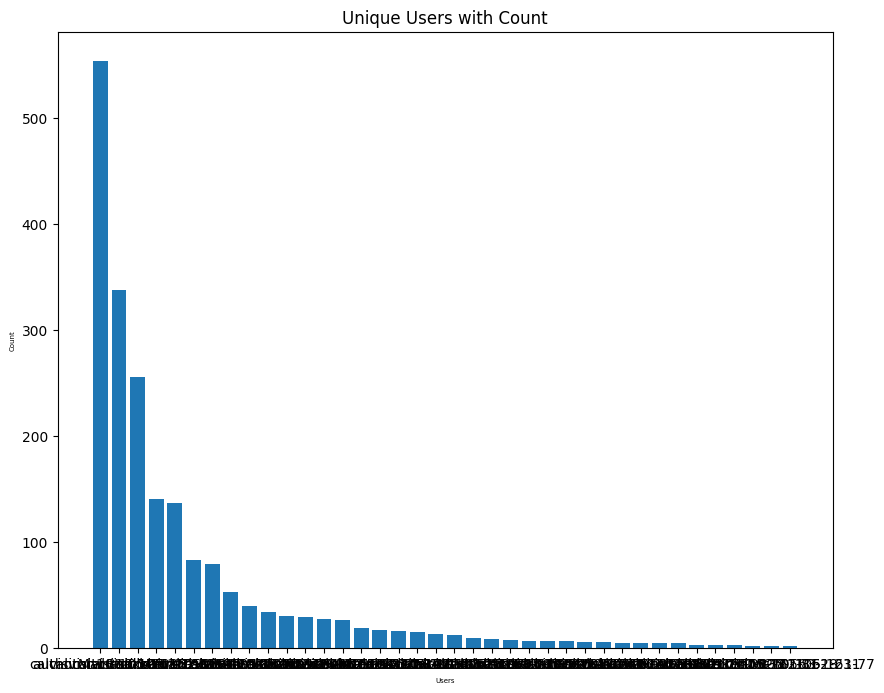

In [121]:
query3 = "Give me the count of the unique users together with the users name in a dataframe"
a3, b3 = agent(query3)

In [77]:
regular_agent = Ollama(model = "llama3.1", temperature = 0)
aa3= regular_agent.invoke(f'Here is the question: {query3}: Here is the output: {a3}. Based on the output summarise it using the question given. Answer should be to the point')

python(5523) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(5562) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


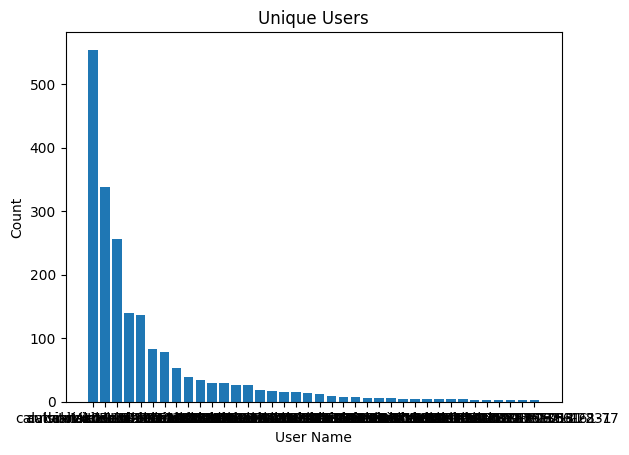

In [88]:
query4 = "Plot a graph of: Give me the count of the unique users together with the users name, "
a4, b4 = agent(query4)

In [90]:
get_extracted_type(b4.last_code_executed)

'plot'

In [102]:
query5 = "Plot a graph of: Give me the count of the unique users together with the users name, make the axis and ticks font-size = 5"
a5, b5 = agent(query5)

Traceback (most recent call last):
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/pipeline.py", line 137, in run
    raise e
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/code_execution.py", line 113, in execute
    raise e
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ch

<Figure size 1000x600 with 0 Axes>

In [113]:
code = b5.last_code_generated

<H1>Refine Dataframe</H1>

In [131]:
regular_agent.invoke(f'Question:{query3}, Output:{a3}. Summarise the result based on the given question')

'Here is a Python code snippet that uses pandas to create a DataFrame from the provided data and then counts the unique users together with their names:\n\n```python\nimport pandas as pd\n\n# Create a dictionary from the provided data\ndata = {\n    "User": [\n        "authorMacBook-Pro",\n        "calvisitor-10-105-162-105",\n        "calvisitor-10-105-162-178",\n        "calvisitor-10-105-160-95",\n        "calvisitor-10-105-163-202",\n        "calvisitor-10-105-160-85",\n        "airbears2-10-142-110-255",\n        "calvisitor-10-105-160-237",\n        "calvisitor-10-105-160-184",\n        "calvisitor-10-105-163-10",\n        "calvisitor-10-105-160-205",\n        "calvisitor-10-105-162-124",\n        "calvisitor-10-105-162-32",\n        "calvisitor-10-105-163-253",\n        "calvisitor-10-105-160-179",\n        "calvisitor-10-105-160-226",\n        "calvisitor-10-105-161-225",\n        "airbears2-10-142-108-38",\n        "calvisitor-10-105-162-107",\n        "calvisitor-10-105-160-3

In [198]:
ans =regular_agent.invoke(f'Here is the question {query3}\n Here is the answer: {a3}\n Are you able to summarise it, answer to the point')
ans_list = ans.split('\n')
for i in ans_list:
    print(i)

Here is a summary:

**Unique Users Count and Name**

| User               | Count |
|--------------------|-------|
| authorMacBook-Pro    | 554   |
| calvisitor-10-105... | 338   |
| ...                 | ...   |

There are **2 unique users**: `authorMacBook-Pro` with 554 counts, and `calvisitor-10-105...` (and others) with varying counts.


<H1>Refine Plot</H1>

python(13724) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(13763) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


'/Users/chuapk/aa/enhancement-pandasAI/exports/charts/temp_chart.png'

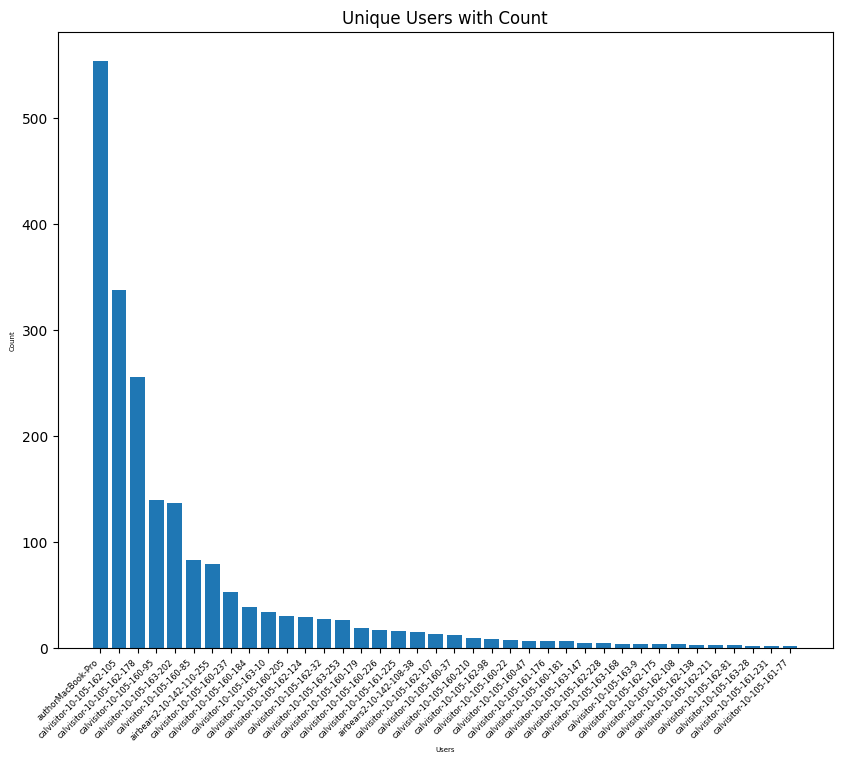

In [115]:
b5.chat(f"refine this code: {code} use plt.xticks(rotation=45, ha='right', fontsize=6)")

In [87]:
aa_final = [i.split('\n') for i in [aa,aa2,aa3]]
for i in aa_final:
    for j in i:
        print(j)
    print("\n[NEXT]\n")

Based on the provided output dataframe, here are the top 5 users:

**Top 5 Users:**

1. **calvisitor-10-105-163-9**: This user appears in all 5 rows of the dataframe.
2. None other user appears more than once.

Note that there is only one unique user value ("calvisitor-10-105-163-9") across all rows, so it is the top user by a significant margin!

[NEXT]

There are 38 unique users.

[NEXT]

Here is a summary of the unique users together with their count:

* authorMacBook-Pro: 554
* airbears2-10-142-108-38: 15
* airbears2-10-142-110-255: 79
* calvisitor-10-105-160-179: 19
* ... (and so on, with a total of 37 unique users)

[NEXT]



In [64]:
c= b.last_code_executed
import re
import ast

get_extracted_type("result = {'type': 'dataframe', 'value': dfs[0].sort_values(by='User', ascending=False).head(5)}")


'dataframe'

<H1>Correlation Analysis</H1>

In [224]:
from pandasai.skills import skill
from pandasai.responses.streamlit_response import StreamlitResponse
from langchain_community.llms import Ollama
import re
llm_code = Ollama(model = 'llama3.1', temperature = 0)
pandas_ai_agent = Agent(
    df, 
    config = {
        "llm" : llm_code,
        "enable_cache" : False,
        "response_parser": StreamlitResponse,
        'verbose': True
        
})
@skill
def corr_analysis(column_name,df, top_n = 10):
    """
    Perform correlation analysis to output the correlation given the data.
    Args:
        column_name (list[str]): column name
        top_n: int

    """

    encode_data = pd.get_dummies(df[['Component', 'User', 'EventId']], drop_first=True)
    correlation_df = encode_data.corr()
    #sns.heatmap(correlation_df, yticklabels=False, xticklabels=False,cmap= 'Blues')
    correlation_matrix_unstacked = correlation_df.unstack().sort_values(ascending=False)
    top_correlations = correlation_matrix_unstacked[correlation_matrix_unstacked!= 1].drop_duplicates()
    print(top_correlations.head(top_n))

# pandas_ai_agent.add_skills(corr_analysis)
prompt = '''
When asked about correlation analysis:
Used enhance the code below to answer the question. It not specified give the top 10 corrlation <top_n> =10:
```python
encode_data = pd.get_dummies(df[['Component', 'User', 'EventId']], drop_first=True)
correlation_df = encode_data.corr()
#sns.heatmap(correlation_df, yticklabels=False, xticklabels=False,cmap= 'Blues')
correlation_matrix_unstacked = correlation_df.unstack().sort_values(ascending=False)
top_correlations = correlation_matrix_unstacked[correlation_matrix_unstacked!= 1].drop_duplicates()
print(top_correlations.head(<top_n>))
```
'''
pandas_ai_agent.chat("Question: perform a correlation analysis given the data"+prompt )
    

User       EventId    0.057535
Component  EventId    0.056974
           User      -0.093459
dtype: float64
User       EventId    0.057535
Component  EventId    0.056974
           User      -0.093459
dtype: float64
User       EventId    0.057535
Component  EventId    0.056974
           User      -0.093459
dtype: float64
User       EventId    0.057535
Component  EventId    0.056974
           User      -0.093459
dtype: float64


Traceback (most recent call last):
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/pipeline.py", line 137, in run
    raise e
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/pipeline.py", line 101, in run
    step_output = logic.execute(
                  ^^^^^^^^^^^^^^
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/code_execution.py", line 113, in execute
    raise e
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/code_execution.py", line 85, in execute
    result = self.execute_code(code_to_run, code_context)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ch

"Unfortunately, I was not able to answer your question, because of the following error:\n\nname 'sns' is not defined\n"

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [200]:
query6 = "perform a correlation analysis given the data"
a6, b6 = agent(query6)


<string>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
<string>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
<string>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
Traceback (most recent call last):
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 335, in run
    ).run(input)
      ^^^^^^^^^^
  File "/Users/chuapk/.pyenv/versions/3.11.5/envs/jy/lib/python3.11/site-packages/pandasai/pi

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

In [203]:
b6.last_code_executed

"df = dfs[0]\ncorr_matrix = df.corr()\nplt.figure(figsize=(12, 9))\nsns.heatmap(corr_matrix, annot=True, cmap='coolwarm')\nplt.tight_layout()\nplt.show()\nresult = {'type': 'plot', 'value': '/Users/chuapk/aa/enhancement-pandasAI/exports/charts/temp_chart.png'}"

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df.corr()
# plt.figure(figsize=(12, 9))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.tight_layout()
# plt.show()
df

/var/folders/lx/851qvbxs21lffwfyc1pptf6c0000gn/T/ipykernel_26631/721057115.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


,LineId,User,Component,PID,Address,Content,EventId,EventTemplate,Combined,Datetime
0,1,calvisitor-10-105-160-95,kernel,0,NaN,IOThunderboltSwitch<0>(0x0)::listenerCallback ...,E252,IOThunderboltSwitch<<*>>(<*>)::listenerCallbac...,Jul 1 09:00:55,1900-07-01 09:00:55
1,2,calvisitor-10-105-160-95,com.apple.CDScheduler,43,NaN,Thermal pressure state: 1 Memory pressure stat...,E323,Thermal pressure state: <*> Memory pressure st...,Jul 1 09:01:05,1900-07-01 09:01:05
2,3,calvisitor-10-105-160-95,QQ,10018,NaN,FA||Url||taskID[2019352994] dealloc,E216,FA||Url||taskID[<*>] dealloc,Jul 1 09:01:06,1900-07-01 09:01:06
3,4,calvisitor-10-105-160-95,kernel,0,NaN,ARPT: 620701.011328: AirPort_Brcm43xx::syncPow...,E128,ARPT: <*>.<*>: AirPort_<*>::syncPowerState: WW...,Jul 1 09:02:26,1900-07-01 09:02:26
4,5,authorMacBook-Pro,kernel,0,NaN,ARPT: 620702.879952: AirPort_Brcm43xx::platfor...,E124,ARPT: <*>.<*>: AirPort_<*>::platformWoWEnable:...,Jul 1 09:02:26,1900-07-01 09:02:26
...,...,...,...,...,...,...,...,...,...,...
1995,1996,calvisitor-10-105-162-124,kernel,0,NaN,ARPT: 790564.863081: wl0: MDNS: IPV6 Addr: 260...,E142,ARPT: <*>.<*>: wl0: MDNS: IPV6 Addr: <*>,Jul 8 07:32:03,1900-07-08 07:32:03
1996,1997,calvisitor-10-105-162-124,kernel,0,NaN,USBMSC Identifier (non-unique): 000000000820 0...,E331,USBMSC Identifier (non-unique): <*>,Jul 8 07:43:38,1900-07-08 07:43:38
1997,1998,calvisitor-10-105-162-124,kernel,0,NaN,AppleCamIn::systemWakeCall - messageType = 0xE...,E120,AppleCamIn::systemWakeCall - messageType = <*>,Jul 8 07:57:11,1900-07-08 07:57:11
1998,1999,calvisitor-10-105-162-124,kernel,0,NaN,Wake reason: RTC (Alarm),E338,Wake reason: RTC (Alarm),Jul 8 08:10:46,1900-07-08 08:10:46


In [108]:
col = df.columns

df.head(3).to_json()
from langchain_community.llms import Ollama
llm=Ollama(model='llama3.1', temperature =0)
llm.invoke(f"""This is the head of the dataframe: {df.head(3).to_json()}
Question: Based on the given data and the fact that `EventId` is an integer representation of `EventTemplate` that categorizes `Content`, determine which columns are most suitable for categorical correlation analysis. 
Choose only one column between `EventId` and `EventTemplate`to avoid redundancy. Provide your reasoning in the output format as follows:
<Thought>: ...
<Final answer>: ['col1', 'col2', 'col3']""")

'{"LineId":{"0":1,"1":2,"2":3},"User":{"0":"calvisitor-10-105-160-95","1":"calvisitor-10-105-160-95","2":"calvisitor-10-105-160-95"},"Component":{"0":"kernel","1":"com.apple.CDScheduler","2":"QQ"},"PID":{"0":0,"1":43,"2":10018},"Address":{"0":null,"1":null,"2":null},"Content":{"0":"IOThunderboltSwitch<0>(0x0)::listenerCallback - Thunderbolt HPD packet for route = 0x0 port = 11 unplug = 0","1":"Thermal pressure state: 1 Memory pressure state: 0","2":"FA||Url||taskID[2019352994] dealloc"},"EventId":{"0":"E252","1":"E323","2":"E216"},"EventTemplate":{"0":"IOThunderboltSwitch<<*>>(<*>)::listenerCallback - Thunderbolt HPD packet for route = <*> port = <*> unplug = <*>","1":"Thermal pressure state: <*> Memory pressure state: <*>","2":"FA||Url||taskID[<*>] dealloc"},"Combined":{"0":"Jul 1 09:00:55","1":"Jul 1 09:01:05","2":"Jul 1 09:01:06"},"Datetime":{"0":-2193317945000,"1":-2193317935000,"2":-2193317934000}}'

In [133]:
prompt=f"""This is the head of the dataframe: {df.head(10).to_json()}\n 
Based on the given data, analyze each key and determine which categorical variables are suitable for analysis. 
- LineID is simply a row identifier and does not need to be included 
- Exclude any columns related to date or time.
- Exclude `Content` because both `EventId` and `EventTemplate` already serve as identifiers for `Content`.
- Ensure that redundant or highly similar columns are not included (e.g., choose only either `EventId` or `EventTemplate`).
The final answer should be a list of the selected categorical variables in the format:
<Thought> ...
<Answer> ["exact key name", "exact key name", ...]"""

for j in range(1):
    for i in ['mistral']:
        llm = Ollama(model = i, temperature  =0)
        out = llm.invoke(prompt)
        print(f'[{i}]\n {out} \n')

[mistral]
  <Thought> The given dataframe contains various columns, some of which are not suitable for analysis due to redundancy or lack of relevance. To select categorical variables for analysis, we should exclude the LineID column as it is simply a row identifier. Additionally, any columns related to date or time should be excluded since the focus here is on categorical variables. The Content column is also excluded because both EventId and EventTemplate already serve as identifiers for Content. Lastly, ensure that redundant or highly similar columns are not included (e.g., choose only either EventId or EventTemplate).
   <Answer> ["User", "Component", "PID", "EventId"] 



In [70]:
 
from regular_agent.agent_ai import Agent_Ai
from langchain_core.prompts import PromptTemplate

agent_ai = Agent_Ai(temperature=0)
prompt =PromptTemplate.from_template("""
Here are a list of example of summary type of questions:
1.Give me a summary of the given data.
2.Can you summarize the key points in the data?
3.What insights can you draw from the data?
4.Provide an overview of the main trends and patterns in the data.
5.Summarize the relationship between the variables in this dataset.
1.	“What is the average value of the EventId column?”
2.	“Which user has the highest number of events?”
3.	“What is the maximum value in the Sales column?”
4.	“Can you filter out all rows where the EventId is greater than 100?”
5.	“Show me the top 5 records with the highest value.”
""")
# question = 'How many rows are there'
# query_summary = f"""
# Using the above example
# Is this: [{question}] a type of summary question
# <Answer> should always be a Yes or No only"""
# out = agent_ai.query_agent(query= query_summary)
# out

In [98]:
for i in prompt.template.split('\n'):
    question = i
    if len(question) < 3:
        continue
    print(question)
    
    
    query_summary = f"""
    You are suppose to determine if the <Question> is explicitly asking for a summary. When determining whether a question is asking for a summary, focus on whether the question is requesting a high-level overview of the data (summary), or if it’s asking for a specific value, action, or detail (non-summary) Always think before answering.
    
    <Question>Is this asking for a summary: {question} 
    <Thought> ...
    <Answer> should always be a Yes or No only
    """
    out = agent_ai.query_agent(query= query_summary)
    print(out)

Here are a list of example of summary type of questions:
<Question>Is this asking for a summary: Here are a list of example of summary type of questions: 

<Thought> ... Upon reviewing the examples, I notice that they all ask for a general overview or a concise representation of data. They don't specify a particular value, action, or detail.

<Answer> Yes
1.Give me a summary of the given data.
<Thought> The question explicitly asks for a "summary" of the given data, which implies a high-level overview rather than a specific detail.

<Answer> Yes
2.Can you summarize the key points in the data?
<Thought> The question explicitly asks to "summarize" the key points, which implies providing an overview of the main ideas. This is a clear indication that the question is asking for a summary.

<Answer> Yes
3.What insights can you draw from the data?
<Thought> The question is asking for "insights" which implies a high-level overview of the data, rather than a specific value, action, or detail. I